1. **Dataclasses for `ParamSpace` and `StateSpace`**
   - Use Python's `@dataclass` decorator to define `ParamSpace` and `StateSpace` classes.

2. **Callable `dynamics`**
   - Define a callable function or method with type annotations that accepts `params` (of type `ParamSpace`) and `state` (of type `StateSpace`) and returns an updated `StateSpace`.

3. **`Model` Class**
   - Attributes:
     - `paramspace`: Instance of `ParamSpace`.
     - `statespace`: Instance of `StateSpace`.
     - `dynamics`: A callable implementing the system dynamics.
   - Methods:
     - **`step`**: Executes the `dynamics` callable for a single step with the provided parameters and state.
     - **`run`**: Iteratively applies `dynamics` `T` times, returning a list of all states, including the initial state.
     - **`batch`**: Runs multiple independent simulations (runs) by iterating through lists of `params` and `initial_states`.

In [1]:
from dataclasses import dataclass
from typing import Callable, List, TypeVar, Generic
import numpy as np

In [2]:
# here is my parametrized dynamical system
@dataclass
class ParamSpace:
    # Define parameters here (example: a simple constant)
    a: float
    b: float

@dataclass
class StateSpace:
    # Define state attributes here (example: simple state variables)
    x: float
    y: float

# Example dynamics function
def example_dynamics(params: ParamSpace, state: StateSpace) -> StateSpace:
    # Simple example of state evolution
    new_x = state.x + params.a
    new_y = state.y + params.b
    return StateSpace(x=new_x, y=new_y)

In [3]:
class Model:
    def __init__(self, 
                 paramspace: ParamSpace, 
                 statespace: StateSpace, 
                 dynamics: Callable[[ParamSpace, StateSpace], StateSpace]):
        self.paramspace = paramspace
        self.statespace = statespace
        self.dynamics = dynamics

    def step(self, params: ParamSpace, state: StateSpace) -> StateSpace:
        """Perform a single dynamics step."""
        return self.dynamics(params, state)

    def run(self, params: ParamSpace, initial_state: StateSpace, T: int) -> List[StateSpace]:
        """Run dynamics for T steps."""
        states = [initial_state]
        current_state = initial_state
        for _ in range(T):
            current_state = self.dynamics(params, current_state)
            states.append(current_state)
        return states

    def batch(self, params: List[ParamSpace], initial_states: List[StateSpace], T: int) -> List[List[StateSpace]]:
        """Run multiple simulations."""
        if len(params) != len(initial_states):
            raise ValueError("params and initial_states must have the same length")
        results = []
        for p, s in zip(params, initial_states):
            results.append(self.run(p, s, T))
        return results
    
    def __repr__(self):
        return f"Model({self.paramspace}, {self.statespace}, {self.dynamics.__annotations__})"


In [4]:

# Create instances of ParamSpace and StateSpace
params = ParamSpace(a=1.0, b=2.0)
initial_state = StateSpace(x=0.0, y=0.0)

print("Initial state:", initial_state)
print("Params:", params)

Initial state: StateSpace(x=0.0, y=0.0)
Params: ParamSpace(a=1.0, b=2.0)


In [5]:
# Instantiate Model with the example dynamics
model = Model(paramspace=params, statespace=initial_state, dynamics=example_dynamics)

print("Model:", model)

Model: Model(ParamSpace(a=1.0, b=2.0), StateSpace(x=0.0, y=0.0), {'params': <class '__main__.ParamSpace'>, 'state': <class '__main__.StateSpace'>, 'return': <class '__main__.StateSpace'>})


In [6]:
# Single step
next_state = model.step(params, initial_state)
print("inital State:", initial_state)
print("Next State:", next_state)

inital State: StateSpace(x=0.0, y=0.0)
Next State: StateSpace(x=1.0, y=2.0)


params: ParamSpace(a=1.0, b=2.0)
Trajectory: [StateSpace(x=0.0, y=0.0), StateSpace(x=1.0, y=2.0), StateSpace(x=2.0, y=4.0), StateSpace(x=3.0, y=6.0), StateSpace(x=4.0, y=8.0), StateSpace(x=5.0, y=10.0)]


Text(0, 0.5, 'y')

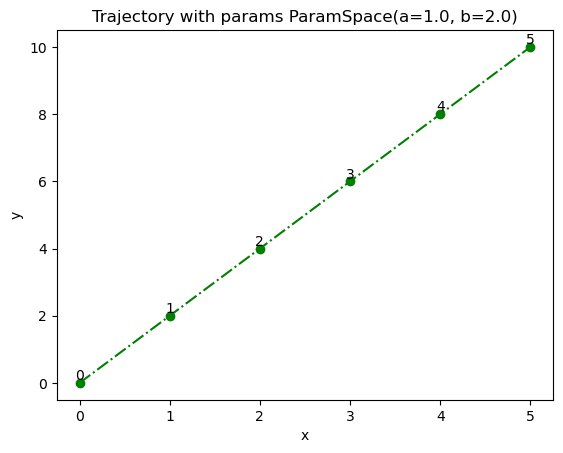

In [7]:
# Run for T steps
trajectory = model.run(params, initial_state, T=5)
print("params:", params)
print("Trajectory:", trajectory)

import matplotlib.pyplot as plt
import numpy as np

plt.figure()
x_values = [state.x for state in trajectory]
y_values = [state.y for state in trajectory]
plt.plot(x_values, y_values, 'o-.', color='green', label=f'Trajectory with params {params}')
for i, (x, y) in enumerate(zip(x_values, y_values)):
    plt.text(x, y, str(i), ha='center', va='bottom')
plt.title(f'Trajectory with params {params}')
plt.xlabel('x')
plt.ylabel('y')


In [8]:

# Batch runs
batch_params = [ParamSpace(a=1.0, b=2.0), ParamSpace(a=0.5, b=-1.5), ParamSpace(a=-1, b=1.0), ParamSpace(a=-.5, b=-2.0)]
batch_initial_states = [StateSpace(x=0.0, y=0.0), StateSpace(x=1.0, y=1.0, ), StateSpace(x=2.0, y=3.0), StateSpace(x=4.0, y=3.0)]
batch_results = model.batch(batch_params, batch_initial_states, T=5)
print("Batch Results:", batch_results)


Batch Results: [[StateSpace(x=0.0, y=0.0), StateSpace(x=1.0, y=2.0), StateSpace(x=2.0, y=4.0), StateSpace(x=3.0, y=6.0), StateSpace(x=4.0, y=8.0), StateSpace(x=5.0, y=10.0)], [StateSpace(x=1.0, y=1.0), StateSpace(x=1.5, y=-0.5), StateSpace(x=2.0, y=-2.0), StateSpace(x=2.5, y=-3.5), StateSpace(x=3.0, y=-5.0), StateSpace(x=3.5, y=-6.5)], [StateSpace(x=2.0, y=3.0), StateSpace(x=1.0, y=4.0), StateSpace(x=0.0, y=5.0), StateSpace(x=-1.0, y=6.0), StateSpace(x=-2.0, y=7.0), StateSpace(x=-3.0, y=8.0)], [StateSpace(x=4.0, y=3.0), StateSpace(x=3.5, y=1.0), StateSpace(x=3.0, y=-1.0), StateSpace(x=2.5, y=-3.0), StateSpace(x=2.0, y=-5.0), StateSpace(x=1.5, y=-7.0)]]


In [45]:
import pandas as pd

data = pd.DataFrame()
for i, (params, states) in enumerate(zip(batch_params, batch_results)):
    df = pd.DataFrame([vars(s) for s in states])
    df['t'] = df.index
    df['run'] = i
    df['a'] = params.a
    df['b'] = params.b
    data = pd.concat([data, df], axis=0)

data

,x,y,t,run,a,b
0,0.0,0.0,0,0,1.0,2.0
1,1.0,2.0,1,0,1.0,2.0
2,2.0,4.0,2,0,1.0,2.0
3,3.0,6.0,3,0,1.0,2.0
4,4.0,8.0,4,0,1.0,2.0
5,5.0,10.0,5,0,1.0,2.0
0,1.0,1.0,0,1,0.5,-1.5
1,1.5,-0.5,1,1,0.5,-1.5
2,2.0,-2.0,2,1,0.5,-1.5
3,2.5,-3.5,3,1,0.5,-1.5


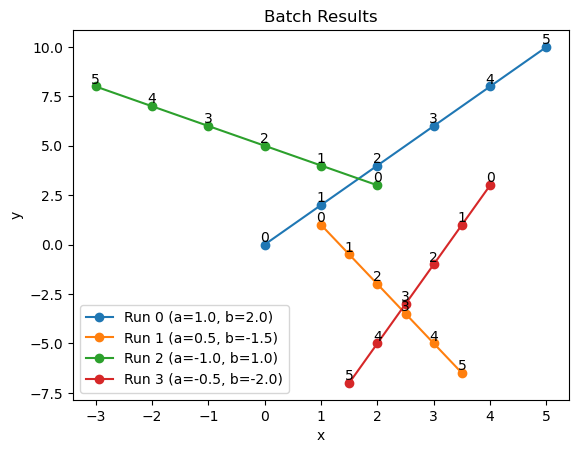

In [10]:
#plotting the batch results
plt.figure()
for i, group in data.groupby('run'):
    plt.plot(group.x, group.y, 'o-', label=f'Run {i}')
    for x, y, t in zip(group.x, group.y, group.t):
        plt.text(x, y, str(t), ha='center', va='bottom')
    plt.title('Batch Results')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(labels=[f'Run {i} (a={group["a"].iloc[0]}, b={group["b"].iloc[0]})' for i, group in data.groupby('run')])
    

In [13]:
#create a class called View which is generic with an attribute which is a class Model, and a method for processing data into a dataframe
class View():
    def __init__(self, model: Model, map: Callable, metrics: Callable):
        self.model = model
        self.map = map
        self.metrics = metrics

    def process(self, data):
        
        return self.metrics(self.map(data))


In [14]:
def my_map(data):
    data = pd.DataFrame()
    for i, (params, states) in enumerate(zip(batch_params, batch_results)):
        df = pd.DataFrame([vars(s) for s in states])
        df['t'] = df.index
        df['run'] = i
        df['a'] = params.a
        df['b'] = params.b
        data = pd.concat([data, df], axis=0)
    return data

def my_metrics(processed_data):
    #metrics computed at the end of the simulation for each state
    processed_data["r"] = np.sqrt(processed_data["x"]**2 + processed_data["y"]**2)
    processed_data["theta"] = np.arctan2(processed_data["y"], processed_data["x"])
    return processed_data

my_view = View(model, my_map, my_metrics)
processed_data = my_view.process(data)

In [15]:
processed_data

,x,y,t,run,a,b,r,theta
0,0.0,0.0,0,0,1.0,2.0,0.000000,0.000000
1,1.0,2.0,1,0,1.0,2.0,2.236068,1.107149
2,2.0,4.0,2,0,1.0,2.0,4.472136,1.107149
3,3.0,6.0,3,0,1.0,2.0,6.708204,1.107149
4,4.0,8.0,4,0,1.0,2.0,8.944272,1.107149
5,5.0,10.0,5,0,1.0,2.0,11.180340,1.107149
0,1.0,1.0,0,1,0.5,-1.5,1.414214,0.785398
1,1.5,-0.5,1,1,0.5,-1.5,1.581139,-0.321751
2,2.0,-2.0,2,1,0.5,-1.5,2.828427,-0.785398
3,2.5,-3.5,3,1,0.5,-1.5,4.301163,-0.950547


while metrics are state level, we are also interested in run level facts

In [34]:
# Create a run level KPI called "arc_length" which is the cumulative sum of delta_theta along the trajectory
# Start by defining a run_data df which has one record for each run
# Drop "t"
# Replace x with x0 (the value of x at t=0) and y with y0 (the value of y at t=0)
run_data = processed_data.groupby('run').apply(lambda x: x.iloc[0]).reset_index(drop=True).drop(columns=['t', 'r', 'theta']).rename(columns={'x': 'x0', 'y': 'y0'})
run_data["arc_length"] = processed_data.groupby('run').apply(lambda x: 360/(2*np.pi) *np.sum(np.diff(x[x["r"] != 0]["theta"]))).values
run_data["requirement"] = np.abs(run_data["arc_length"]) < 90

In [35]:
run_data

,x0,y0,run,a,b,arc_length,requirement
0,0.0,0.0,0.0,1.0,2.0,0.000000,True
1,1.0,1.0,1.0,0.5,-1.5,-106.699244,False
2,2.0,3.0,2.0,-1.0,1.0,54.246113,True
3,4.0,3.0,3.0,-0.5,-2.0,-114.775141,False


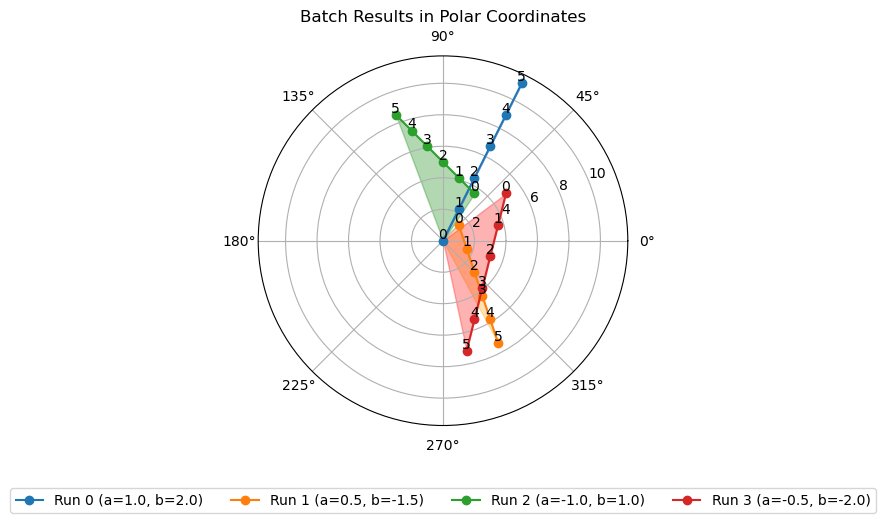

In [44]:
#plot the the cones so we can see the arc length requirement visually
plt.figure()
lines = []
labels = []
for i, group in processed_data.groupby('run'):
    line, = plt.polar(group.theta, group.r, 'o-', label=f'Run {i}')
    lines.append(line)
    labels.append(f'Run {i} (a={group["a"].iloc[0]}, b={group["b"].iloc[0]})')
    for theta, r, t in zip(group.theta, group.r, group.t):
        plt.text(theta, r, str(t), ha='center', va='bottom')
    plt.title('Batch Results in Polar Coordinates')
    color_map = {0: 'blue', 2: 'green', 1: 'orange', 3: 'red'}
    plt.fill_between(group.theta, group.r, color=color_map[i], alpha=0.3)
plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)